In [1]:
import segmentation_models_pytorch as smp
import torch
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, OneCycleLR
from tqdm import tqdm, trange
from torchinfo import summary

In [2]:
# Устройство для обучения
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", device)

Current device: cuda


## Настройка параметров

In [3]:
LOAD_MODEL = False  # Пропустить обучение модели

# Директории с датасетами
TRAIN_PATH        = './train/'
TRAIN_LABELS_PATH = './train_labels/'

VAL_PATH        = './val'
VAL_LABELS_PATH = './val_labels/'

TEST_PATH        = './test'
TEST_LABELS_PATH = './test_labels./'

# Параметры загрузчиков
BACTH_SIZE  = 1
NUM_WORKERS = 0
PIN_MEMORY  = True

# Параметры оптимизатора
WEIGHT_DECAY  = 5e-5
LEARNING_RATE = 5e-3

MEAN = [0.3395, 0.3431, 0.3020]
STD  = [0.3908, 0.3897, 0.3542]

# Параметры планировщика
FACTOR    = 0.1
PATIENCE  = 10
THRESHOLD = 1e-4

# Параметры модели
ENCODER         = 'resnet50'
ENCODER_WEIGHTS = None

# Параметры обучения
NUM_EPOCHS = 30

# Параметры датасета
ORIGINAL_SIZE = 1500
PADED_SIZE    = 1536
PATCH_SIZE    = 256 

## Нарезка изображений

In [4]:
class ToPatches(object):
    
    def __init__(self, patch_size = 256):
        self.patch_size = patch_size

    def __call__(self, image = None, mask = None):

        if image is not None:
            image = image.unfold(0, 3, 3).unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
            image = image.contiguous().view(-1, 3, self.patch_size, self.patch_size)

        if mask is not None:
            mask = mask.unfold(0, self.patch_size, self.patch_size).unfold(1, self.patch_size, self.patch_size)
            mask = mask.contiguous().view(-1, 1, self.patch_size, self.patch_size)

        return {'image' : image, 'mask' : mask}

## Склейка изображений

In [5]:
def FromPatches(image = None, mask = None, predict = None):
    
    if image is not None:   
        image = image.view(torch.Size([1, 1, 6, 6, 3, 256, 256]))
        image = image.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
        image = image.view(1, 3, 1536, 1536)

    if mask is not None:
        mask = mask.view(torch.Size([1, 1, 6, 6, 1, 256, 256]))
        mask = mask.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
        mask = mask.view(1, 1, 1536, 1536)

    if predict is not None:
        predict = predict.view(torch.Size([1, 1, 6, 6, 1, 256, 256]))
        predict = predict.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
        predict = predict.view(1, 1, 1536, 1536)

    return {'image' : image, 'mask' : mask, 'predict' : predict}

## Настройка аугментаций

In [6]:
train_transform = A.Compose([
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5),
        A.RandomRotate90(p = 0.5),
        A.RandomBrightnessContrast(brightness_limit = 0.1, contrast_limit = 0.1, p = 0.5),
        A.PadIfNeeded(PADED_SIZE, PADED_SIZE, border_mode = 0),
        A.Normalize(mean = MEAN, std = STD),        
        ToTensorV2(),
        ToPatches()])

val_test_transform = A.Compose([
    A.PadIfNeeded(PADED_SIZE, PADED_SIZE, border_mode = 0),
    A.Normalize(mean = MEAN, std = STD),
    ToTensorV2(),
    ToPatches()])

## Подготовка датасетов

In [7]:
class road_Dataset(Dataset):

    def __init__(self, images_dir, masks_dir, transforms = None):

        self.images_dir = images_dir
        self.masks_dir  = masks_dir
        self.transforms = transforms
        self.images     = os.listdir(images_dir)

    def __getitem__(self, id):

        image = cv2.cvtColor(cv2.imread(os.path.join(self.images_dir, self.images[id])), cv2.COLOR_BGR2RGB)
        mask  = cv2.cvtColor(cv2.imread(os.path.join(self.masks_dir, self.images[id].replace(".tiff", ".tif"))), cv2.COLOR_RGB2GRAY)

        mask[mask == 255] = 1

        if self.transforms:
            transformed = self.transforms(image = image, mask = mask)
            image = transformed['image']
            mask  = transformed['mask']    

        return image, mask
    
    def __len__(self):
        return len(self.images)

In [8]:
# Создание датасетов
train_dataset = road_Dataset(TRAIN_PATH, TRAIN_LABELS_PATH, transforms = train_transform)
val_dataset   = road_Dataset(VAL_PATH, VAL_LABELS_PATH, transforms = val_test_transform)
test_dataset  = road_Dataset(TEST_PATH, TEST_LABELS_PATH, transforms = val_test_transform)

## Создание загрузчиков 

In [9]:
train_loader = DataLoader(train_dataset, batch_size = BACTH_SIZE, shuffle = True, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY)
val_loader   = DataLoader(val_dataset, batch_size = BACTH_SIZE, shuffle = True, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY)
test_loader  = DataLoader(test_dataset, batch_size = BACTH_SIZE, shuffle = True, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY)

## Расчет среднего и стандартного отклонения

In [10]:
if MEAN == None or STD == None:

    MEAN = torch.zeros(3)
    STD  = torch.zeros(3)

    dataset = road_Dataset(TRAIN_PATH, TRAIN_LABELS_PATH, transforms = train_transform)
    loader  = DataLoader(dataset, batch_size = 1)

    cnt = len(dataset) * ORIGINAL_SIZE ** 2 * dataset[0].shape[0]

    for images, _ in tqdm(loader):

        images = images.squeeze(0)
        
        MEAN += images.sum(axis = [0, 2, 3])
        STD  += (images ** 2).sum(axis = [0, 2, 3])



AttributeError: 'road_Dataset' object has no attribute 'mean'

## Вывод изображений с масками

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


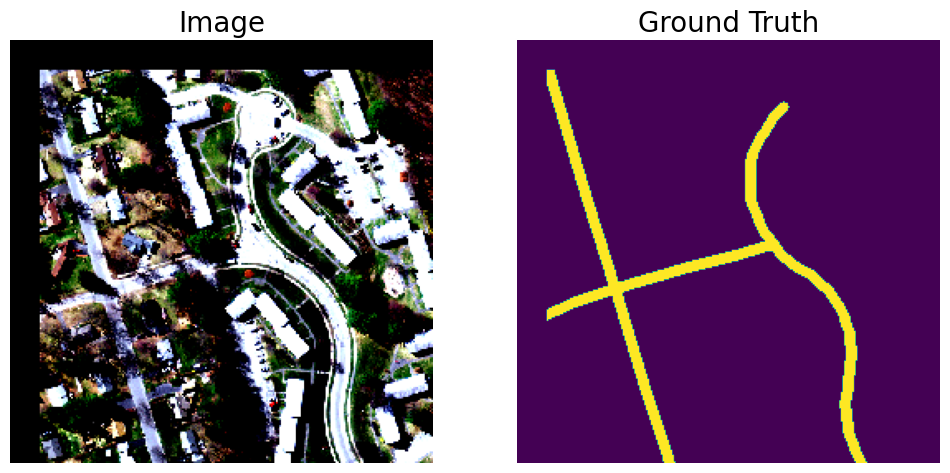

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


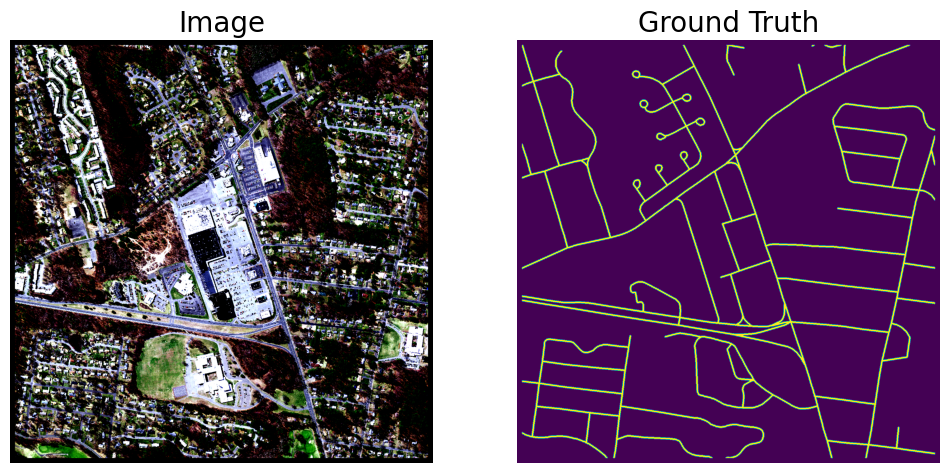

In [10]:
# Вывод заданного количества изображений
def imshow(images, targets, predicts = None, cnt = 1):

    imgs_in_row = 2

    # Подготовка холста для изображений
    if predicts != None:
        imgs_in_row = 3

    fig, axs = plt.subplots(cnt, imgs_in_row) 
    fig.set_figwidth(imgs_in_row * 6)
    fig.set_figheight(cnt * 6)

    axs = axs.flatten()

    for i, (image, mask) in enumerate(zip(images[:cnt], targets[:cnt])):
    
        # Приведение массивов к формату (H, W, Ch)
        np_img  = image.numpy()
        np_mask = mask.numpy().squeeze()

        np_img = np.transpose(np_img, (1, 2, 0)).squeeze()

        # Вывод изображения
        axs[i * imgs_in_row].imshow(np_img)
        axs[i * imgs_in_row + 1].imshow(np_mask)

        axs[i * imgs_in_row].set_axis_off()
        axs[i * imgs_in_row + 1].set_axis_off()

        if predicts != None:
            np_predict = predicts[i].numpy().squeeze()
            axs[i * imgs_in_row + 2].imshow(np_predict)
            axs[i * imgs_in_row + 2].set_axis_off()

        if i == 0:
            axs[i * imgs_in_row].set_title('Image', fontsize = 20)
            axs[i * imgs_in_row + 1].set_title('Ground Truth', fontsize = 20)

            if predicts != None:
                axs[i * imgs_in_row + 2].set_title('Predicted Mask', fontsize = 20)
 
    plt.show()
   
# Получить случайные тренировочные изображения
images, targets = next(iter(train_loader))
imshow(images.squeeze(0), targets.squeeze(0), cnt = 1)

orig_images = FromPatches(images, targets)
imshow(orig_images['image'], orig_images['mask'], cnt = 1)

## Создание модели

In [11]:
model     = smp.Unet(encoder_name = ENCODER, encoder_weights = ENCODER_WEIGHTS, classes = 1).to(device)
#criterion = smp.losses.SoftBCEWithLogitsLoss().to(device)
criterion = torch.nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
#schedule  = OneCycleLR(optimizer, max_lr = 0.1, steps_per_epoch = len(train_loader), epochs = NUM_EPOCHS)
schedule  = ReduceLROnPlateau(optimizer, factor = FACTOR, patience = PATIENCE, threshold = THRESHOLD, min_lr = 1e-6)
#schedule = CosineAnnealingWarmRestarts(optimizer, T_0 = 1, T_mult = 2, eta_min = 5e-5)

# Загрузить сохраненные веса в модель
if LOAD_MODEL:
    model.load_state_dict(torch.load('./weights.h5'))

## Обучение модели

In [12]:
if not LOAD_MODEL:

    # Значения функции потерь в течение обучения
    train_losses = np.zeros(NUM_EPOCHS) 
    val_losses   = np.zeros(NUM_EPOCHS)

    # Значения IOU в течение обучения
    train_IOUs = np.zeros(NUM_EPOCHS) 
    val_IOUs   = np.zeros(NUM_EPOCHS)

    lrs = []
    
    for epoch in (pbar := trange(NUM_EPOCHS)):
        
        torch.save(model.state_dict(), './weights.h5')
        best_IOU = 0

        stats = []
        model.train()

        for images, targets in train_loader:  

            images  = images.squeeze(0).float().to(device)
            targets = targets.squeeze(0).float().to(device)
            
            # Прямой проход
            predict = model(images)
            loss = criterion(predict, targets)           
            train_losses[epoch] += loss.item()

            predict = predict.sigmoid()
            predict = predict >= 0.5
            
            masks = FromPatches(mask = targets.long(), predict = predict.long())

            tp, fp, fn, tn = smp.metrics.get_stats(masks['predict'], masks['mask'], mode = 'binary', threshold = 0.5)
            stats.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
        
            tp = torch.cat([x["tp"] for x in stats])
            fp = torch.cat([x["fp"] for x in stats])
            fn = torch.cat([x["fn"] for x in stats])
            tn = torch.cat([x["tn"] for x in stats])

            # Обратный проход
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            lrs.append(optimizer.param_groups[0]["lr"])

            #schedule.step()
            
        train_IOUs[epoch]    = 100 * smp.metrics.iou_score(tp, fp, fn, tn, reduction = 'micro-imagewise').item()
        train_losses[epoch] /= len(train_loader)

        #schedule.step()

        # Валидация
        with torch.no_grad():
            
            stats = []
            model.eval()

            for images, targets in val_loader:

                images  = images.squeeze(0).float().to(device)
                targets = targets.squeeze(0).float().to(device)

                # Прямой проход
                predict = model(images)      
                loss = criterion(predict, targets)
                val_losses[epoch] += loss.item()

                predict = predict.sigmoid()
                predict = predict >= 0.5

                masks = FromPatches(mask = targets.long(), predict = predict.long())

                tp, fp, fn, tn = smp.metrics.get_stats(masks['predict'], masks['mask'], mode = 'binary', threshold = 0.5)
                
                stats.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})

            tp = torch.cat([x["tp"] for x in stats])
            fp = torch.cat([x["fp"] for x in stats])
            fn = torch.cat([x["fn"] for x in stats])
            tn = torch.cat([x["tn"] for x in stats])

            val_IOUs[epoch]    = 100 * smp.metrics.iou_score(tp, fp, fn, tn, reduction = 'micro-imagewise').item()
            val_losses[epoch] /= len(val_loader)

            # Сохранение весов, если результат на текущей эпохе лучше
            if best_IOU < val_IOUs[epoch]:
                best_IOU = val_IOUs[epoch]
                torch.save(model.state_dict(), './weights.h5')

        schedule.step(val_losses[epoch])
        pbar.set_description(f'Avg. train/valid loss: [{train_losses[epoch]:.2f}/{val_losses[epoch]:.2f}], train/valid IOU: [{train_IOUs[epoch]:.2f}%/{val_IOUs[epoch]:.2f}%]')

    # Загрузка и сохранение лучших весов
    model.load_state_dict(torch.load('./weights.h5'))


Avg. train/valid loss: [0.10/0.18], train/valid IOU: [41.38%/12.04%]:  20%|██        | 6/30 [30:20<1:59:59, 299.96s/it]

## Графики

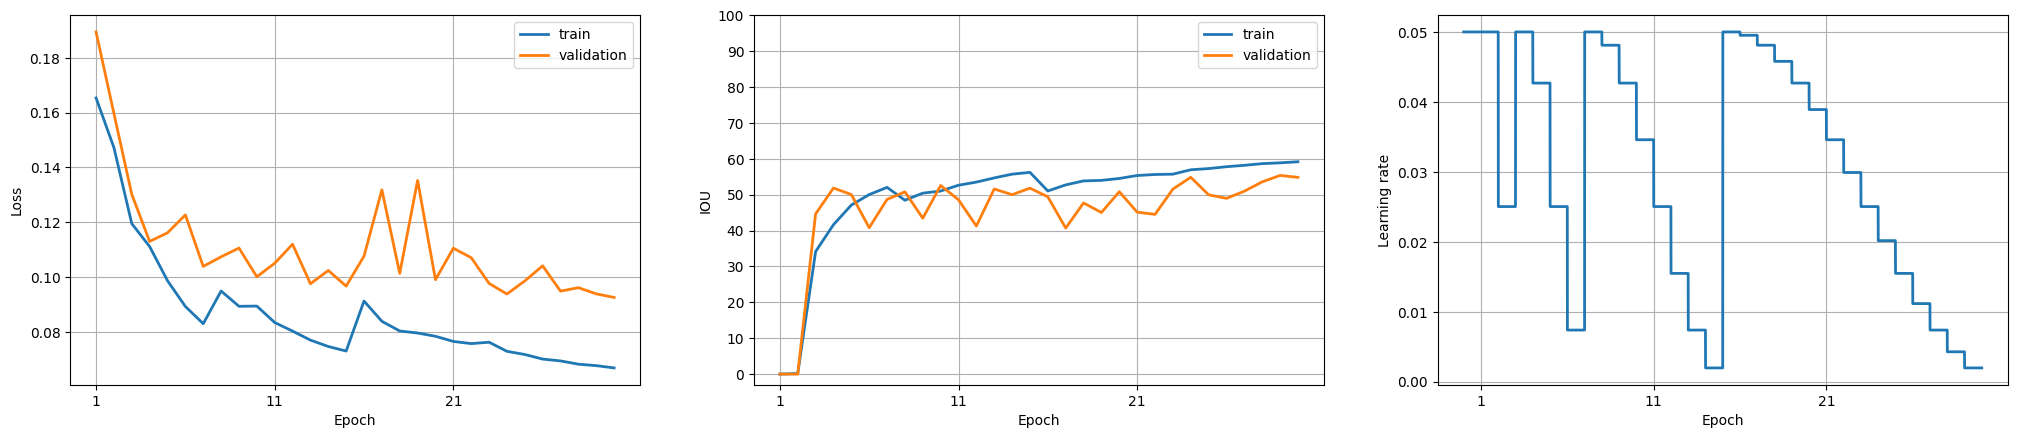

In [ ]:
if not LOAD_MODEL:
    
    step = 10

    fig, axs = plt.subplots(1, 3)
    fig.set_figwidth(25) 

    axs[0].plot(range(1, NUM_EPOCHS + 1), train_losses, linewidth = 2, label = 'train')
    axs[0].plot(range(1, NUM_EPOCHS + 1), val_losses, linewidth = 2, label = 'validation')
    axs[0].set_xticks(range(1, NUM_EPOCHS + 1, step))
    axs[0].set_xlabel('Epoch') 
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(range(1, NUM_EPOCHS + 1), train_IOUs, linewidth = 2, label = 'train')
    axs[1].plot(range(1, NUM_EPOCHS + 1), val_IOUs, linewidth = 2, label = 'validation')
    axs[1].set_xticks(range(1, NUM_EPOCHS + 1, step))
    axs[1].set_yticks(range(0, 101, 10))
    axs[1].set_xlabel('Epoch') 
    axs[1].set_ylabel('IOU')
    axs[1].legend()
    axs[1].grid()

    axs[2].plot(np.linspace(0, NUM_EPOCHS, len(lrs)), lrs, linewidth = 2)
    axs[2].set_xticks(range(1, NUM_EPOCHS + 1, step))
    axs[2].set_xlabel('Epoch') 
    axs[2].set_ylabel('Learning rate')
    axs[2].grid()

    plt.show()

## Тестирование модели

In [ ]:
stats = []
model.eval()

with torch.no_grad():
    for i, (images, targets) in enumerate(test_loader):
        
        images  = images.squeeze().float().to(device)
        targets = targets.squeeze().float().to(device)

        # Прямой проход
        predict = model(images).sigmoid()
        predict = predict >= 0.5      

        orig_images = FromPatches(image = images, mask = targets.long(), predict = predict.long())

        tp, fp, fn, tn = smp.metrics.get_stats(orig_images['predict'], orig_images['mask'], mode = 'binary', threshold = 0.5)
        stats.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
        
        # Отобразить изображения с предсказанными масками
        if i < 5:
            imshow(orig_images['image'].cpu(), orig_images['mask'].cpu(), orig_images['predict'].cpu(), cnt = 1)
    
    tp = torch.cat([x["tp"] for x in stats])
    fp = torch.cat([x["fp"] for x in stats])
    fn = torch.cat([x["fn"] for x in stats])
    tn = torch.cat([x["tn"] for x in stats])

    IOU = smp.metrics.iou_score(tp, fp, fn, tn, reduction = 'micro-imagewise').item()
    print('IOU-score of the network on the {} testing images: {:.4f} %'.format(len(test_loader), 100 * IOU))